In [139]:
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [140]:
import numpy as np
import pandas as pd

In [141]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [142]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [143]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [144]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [145]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [146]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [147]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [148]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date one year from the last date in data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [149]:
twelve_months = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

twelve_months_data = session.query(Measurement.date, Measurement.prcp).\
                     filter(Measurement.date >= twelve_months).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

twelve_months_df = pd.DataFrame(twelve_months_data, columns=["Date", "Precipitation"])
twelve_months_df.set_index('Date', inplace=True)

# Sort the dataframe by date

twelve_months_df.sort_values(["Date"])
twelve_months_df["Precipitation"].fillna(0, inplace=True)
twelve_months_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


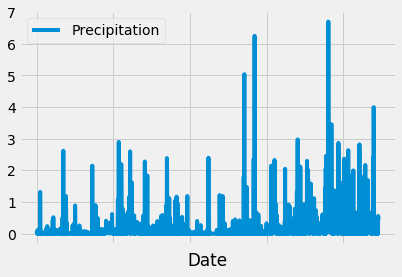

In [150]:
# Use Pandas Plotting with Matplotlib to plot the data
twelve_months_df.plot()

In [151]:
# Use Pandas to calcualte the summary statistics for the precipitation data
twelve_months_df.describe()

,Precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Station Analysis

In [152]:
# How many stations are available in this dataset?
number_stations = session.query(Station.station).count()

print(f"There are {number_stations} stations.")

There are 9 stations.


In [153]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.id)).\
              group_by(Measurement.station).\
              order_by(func.count(Measurement.id).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [154]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
              filter(Measurement.station == "USC00519281").all()


[(54.0, 85.0, 71.66378066378067)]

In [155]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station = session.query(Measurement.tobs).\
              filter(Measurement.station == "USC00519281").\
              filter(Measurement.date >= twelve_months).all()

most_active_station_df = pd.DataFrame(most_active_station, columns=["Temperature"])
most_active_station_df.describe()


,Temperature
count,352.000000
mean,73.107955
std,4.733315
min,59.000000
25%,70.000000
50%,74.000000
75%,77.000000
max,83.000000


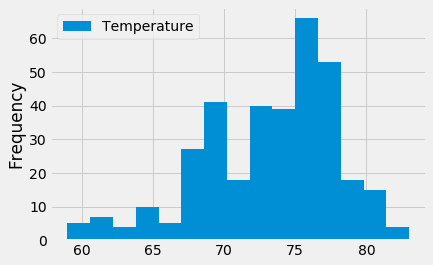

In [156]:
most_active_station_df.plot.hist(bins=15, range=[59,83])

# Temperature Analysis

In [157]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [158]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#print(calc_temps('2017-01-01', '2017-01-15'))
trip_temp = calc_temps('2017-01-01', '2017-01-15')
trip_data = list(np.ravel(trip_temp))
trip_data

[60.0, 68.5505617977528, 81.0]

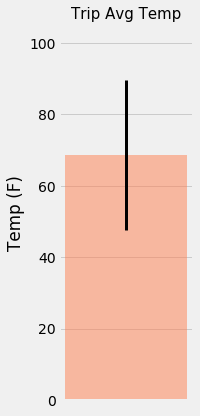

In [159]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

TAVG = trip_data[1]
peak = [trip_data[2] - trip_data[0]]

# Create Arrays for the plot
x = 1
y = TAVG
error = peak

# Build the plot
fig, ax = plt.subplots()
fig.set_size_inches(3,6) 
ax.bar(x, y, yerr=error, align='center', color="coral", alpha=0.5, width=.50, error_kw=dict(elinewidth=3))

ax.set_ylabel('Temp (F)')
ax.set_title('Trip Avg Temp', fontsize=15)
ax.xaxis.grid(False)
ax.yaxis.grid(True)
ax.set_ylim(0, 105)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# Save the figure and show
plt.tight_layout()
plt.show()

# Other recommended analysis

In [160]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Measurement.station, Station.name,  Station.latitude, Station.longitude, \
       Station.elevation, func.sum(Measurement.prcp)]

rainfall_trip_dates = session.query(*sel).filter(Measurement.station == Station.station).\
                      filter(Measurement.date >= "2016-01-01").\
                      filter(Measurement.date <= "2016-01-15").\
                      group_by(Measurement.station).\
                      order_by (func.sum(Measurement.prcp).desc()).all()

print(rainfall_trip_dates)



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 2.9400000000000004), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.03), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.6900000000000001), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.6100000000000001), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.23), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.13), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [161]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [162]:
#Create a list of dates for your trip in the format %m-%d. 

daterange = pd.date_range("2017-01-01", "2017-01-15")

my_dates = []

for single_date in daterange:
    day = (single_date.strftime("%m-%d"))
    my_dates.append(day)

#Use the daily_normals function to calculate the normals for each date string and append the results to a list.

daily_normal_my_dates = []

for date in my_dates:
    new_list = daily_normals(date)
    daily_normal_my_dates.append(new_list)

daily_normal_my_dates

[[(62.0, 69.15384615384616, 77.0)],
 [(60.0, 69.39622641509433, 77.0)],
 [(62.0, 68.9090909090909, 77.0)],
 [(58.0, 70.0, 76.0)],
 [(56.0, 67.96428571428571, 76.0)],
 [(61.0, 68.96491228070175, 76.0)],
 [(57.0, 68.54385964912281, 76.0)],
 [(57.0, 67.16071428571429, 75.0)],
 [(58.0, 67.9298245614035, 78.0)],
 [(62.0, 69.74137931034483, 77.0)],
 [(57.0, 67.3103448275862, 78.0)],
 [(57.0, 67.4074074074074, 81.0)],
 [(57.0, 67.25454545454545, 77.0)],
 [(58.0, 69.52631578947368, 77.0)],
 [(56.0, 69.31372549019608, 78.0)]]

In [180]:
output = []
for x in daily_normal_my_dates:
    output.append([element for tupl in x for element in tupl])
    
output

[[62.0, 69.15384615384616, 77.0],
 [60.0, 69.39622641509433, 77.0],
 [62.0, 68.9090909090909, 77.0],
 [58.0, 70.0, 76.0],
 [56.0, 67.96428571428571, 76.0],
 [61.0, 68.96491228070175, 76.0],
 [57.0, 68.54385964912281, 76.0],
 [57.0, 67.16071428571429, 75.0],
 [58.0, 67.9298245614035, 78.0],
 [62.0, 69.74137931034483, 77.0],
 [57.0, 67.3103448275862, 78.0],
 [57.0, 67.4074074074074, 81.0],
 [57.0, 67.25454545454545, 77.0],
 [58.0, 69.52631578947368, 77.0],
 [56.0, 69.31372549019608, 78.0]]

In [181]:
df = pd.DataFrame(output, columns=["tmin", "tavg", "tmax"])
df.insert(3, "Year", "2018")
df.insert(4,"days", my_dates)
df.head()

,tmin,tavg,tmax,Year,days
0,62.0,69.153846,77.0,2018,01-01
1,60.0,69.396226,77.0,2018,01-02
2,62.0,68.909091,77.0,2018,01-03
3,58.0,70.000000,76.0,2018,01-04
4,56.0,67.964286,76.0,2018,01-05


In [182]:
df["date"] = df["Year"].map(str) + '-' + df['days'].map(str)
df.set_index(["date"], inplace=True)
df.drop(df.columns[[3, 4]], axis=1, inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


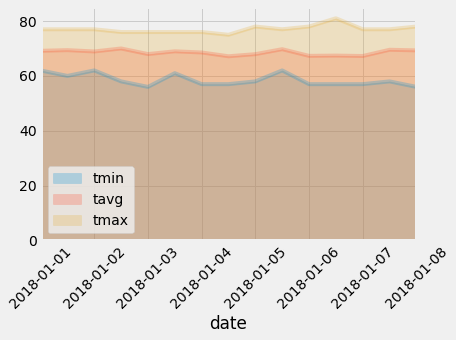

In [184]:
# Plot the daily normals as an area plot with `stacked=False`

ax = df.plot(kind='area', stacked=False, alpha=.25)
x_labels = df.index
ax.set_xticklabels(x_labels, rotation=45)
ax.margins(0, 0) # Set margins to avoid "whitespace"

plt.show()